### INTRODUCTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True) :
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l, 'Max Length': max_l, 'Level_Values' : unq} )
    return levels

In [3]:
df=pd.read_csv("/Users/onkar/Downloads/SBA_archive/SBAnational.csv")

In [4]:
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [5]:
df.shape

(899164, 27)

## 1. DATA CLEANING

##### According to the dataset documentation provided :

There are a number of variables that consistently emerge as indicators of risk that could explain the variation of loan default rates. Seven variables, along with some exploratory analysis, are discussed below including Location (State), Industry, Gross Disbursement, New vs Established Business, Loans Backed by Real Estate, Economic Recession, and SBA's Guaranteed Portion of Approved Loan.
 

In [6]:
df=df.drop_duplicates(keep='first')   # delete duplicates, if any

In [7]:
df.isna().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [8]:
df.dropna(subset=['MIS_Status','RevLineCr','LowDoc','Bank','BankState',
                  'Name','City','State','NewExist','DisbursementDate'],inplace=True)

# dropped all but ChgOffDate null values as we do not really need that column in particular

In [9]:
df['MIS_Status'].value_counts()   # we want to see how many loans have defaulted, indicated by status as 'CHGOFF'

P I F     730199
CHGOFF    156041
Name: MIS_Status, dtype: int64

<AxesSubplot:xlabel='MIS_Status', ylabel='count'>

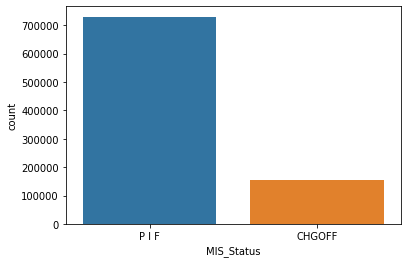

In [10]:
sns.countplot(x='MIS_Status', data=df)

In [11]:
df=df.drop(axis=1,columns=['ChgOffDate'])   # dropped ChgOffDate column

In [12]:
describe_more(df)

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,LoanNr_ChkDgt,886240,int64,10,10,"{1000014003: 1, 5934054006: 1, 5933964006: 1, ..."
1,Name,769838,object,1,30,"{'SUBWAY': 1259, 'QUIZNO'S SUBS': 433, 'COLD S..."
2,City,32298,object,1,30,"{'LOS ANGELES': 11467, 'HOUSTON': 10129, 'NEW ..."
3,State,51,object,2,2,"{'CA': 129398, 'TX': 69348, 'NY': 56869, 'FL':..."
4,Zip,33501,int64,1,5,"{10001: 919, 90015: 917, 93401: 749, 90010: 73..."
5,Bank,5788,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 86075, 'WELLS F..."
6,BankState,56,object,2,2,"{'CA': 116737, 'NC': 78708, 'IL': 64919, 'OH':..."
7,NAICS,1311,int64,1,6,"{0: 198267, 722110: 27772, 722211: 19338, 8111..."
8,ApprovalDate,9786,object,8,9,"{'7-Jul-93': 1120, '30-Jan-04': 1028, '8-Jul-9..."
9,ApprovalFY,64,object,4,5,"{2006: 75657, 2007: 71406, 2003: 57688, 2005: ..."



##### # We see here that some records of DisbursementGross, BalanceGross, ChgOffPrinGr, GrAppv & SBA_Appv are being read as objects (strings) instead of numbers (integers)


##### > Some things we note or want to do are: 

     1. drop records that dont have Y or N values of LowDoc
     2. some ApprovalFY records are also not integers
     3. drop NewExist records that have value 0
     4. convert ApprovalDate and DisbursementDate columns to datetime values
 

In [13]:
cols_mess=["DisbursementGross", "BalanceGross", "ChgOffPrinGr", "GrAppv", "SBA_Appv"]
df[cols_mess]=df[cols_mess].astype(str).replace("[']","",regex=True)   # drop single quotation marks
df[cols_mess]=df[cols_mess].astype(str).replace("[,]","",regex=True)   # drop commas
df[cols_mess]=df[cols_mess].astype(str).replace("[$]","",regex=True)   # drop $ sign

df[cols_mess]=df[cols_mess].astype(float)   # convert the cols_mess columns to float data type

df[cols_mess].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886240 entries, 0 to 899163
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DisbursementGross  886240 non-null  float64
 1   BalanceGross       886240 non-null  float64
 2   ChgOffPrinGr       886240 non-null  float64
 3   GrAppv             886240 non-null  float64
 4   SBA_Appv           886240 non-null  float64
dtypes: float64(5)
memory usage: 72.8 MB


In [14]:
df["ApprovalFY"].unique()   # note that some years are within quotation marks and one is followed by an A

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1982, 1983, 1973, 1984, 2007, 1985, 1986, 1987,
       2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010, 2011, 1992, 1993,
       2002, 2012, 2013, 1994, 2014, 1975, 1977, 1976, '2004', '1994',
       '1979', '1976', '1975', '1974', '1977', '1981', '1982', '1983',
       '1984', '1978', '1980', '1968', '1976A', '1969', '1995', '1970',
       '2005', '1996', '1971', 1996, 1971], dtype=object)

In [15]:
df["ApprovalFY"]=df["ApprovalFY"].astype(str).replace("'","",regex=True)
df["ApprovalFY"]=df["ApprovalFY"].astype(str).replace("A","",regex=True)

df["ApprovalFY"]=df["ApprovalFY"].astype(int)   # convert ApprovalFY dtype from object to int

df["ApprovalFY"].dtype

dtype('int64')

In [16]:
df = df[(df['LowDoc']=='Y') | (df['LowDoc']=='N')]   # dropped all but Y/N records in LowDoc
df['LowDoc'].isna().sum()

0

In [17]:
df = df[(df['NewExist']==1) | (df['NewExist']==2)]   # dropped unspecified values (0) in NewExist
df["NewExist"]=df["NewExist"].astype(int)

print(df["NewExist"].isna().sum())
print(df["NewExist"].dtype)

0
int64


##### # Some of the fields that are considered flags already but aren't necessarily in a useable format right now. 
These include the NewExist, RevLineCr, LowDoc, and MIS_Status fields; some of which need fixing. 
##### 

In [18]:
df['MIS_Status'].where(~(df["MIS_Status"]=='P I F'), other=0, inplace=True)    # replace PIF as 0
df['MIS_Status'].where(~(df["MIS_Status"]=='CHGOFF'), other=1, inplace=True)   # replace CHGOFF as 1

df["MIS_Status"]=df["MIS_Status"].astype(int)
df["MIS_Status"].dtype

dtype('int64')

In [19]:
df['LowDoc'].where(~(df["LowDoc"]=='N'), other=0, inplace=True)   # replace N as 0
df['LowDoc'].where(~(df["LowDoc"]=='Y'), other=1, inplace=True)   # replace Y as 1

df["LowDoc"]=df["LowDoc"].astype(int)
df["LowDoc"].dtype

dtype('int64')

##### > We can now work to clean RevLineCr which has a large records (especially of 0) having unneccessary values

In [20]:
df["RevLineCr"].value_counts()

N    412142
0    256725
Y    198045
T     15091
1        22
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: RevLineCr, dtype: int64

In [21]:
df = df[(df['RevLineCr']=='Y') | (df['RevLineCr']=='N') | (df['RevLineCr']=='0')]
df["RevLineCr"].value_counts()   # dropped all garbage value of RevLineCr and left 0 as unknown factor

N    412142
0    256725
Y    198045
Name: RevLineCr, dtype: int64

In [22]:
df['RevLineCr'].where(~(df["RevLineCr"]=='N'), other=0, inplace=True)   # replace N as 0
df['RevLineCr'].where(~(df["RevLineCr"]=='Y'), other=1, inplace=True)   # replace Y as 1
df['RevLineCr'].where(~(df["RevLineCr"]==0), other=-1, inplace=True)    # replace 0 as -1

df["RevLineCr"]=df["RevLineCr"].astype(int)
df["RevLineCr"].dtype

dtype('int64')

##### > Convert ApprovalDate and DisbursementDate columns to datetime values

In [23]:
from datetime import date

df[['ApprovalDate','DisbursementDate']]=df[['ApprovalDate','DisbursementDate']].apply(
                                            lambda x: pd.to_datetime(x,errors = 'coerce'))

##### > Check if all missing values have been dealt with

In [24]:
df.isna().sum()

LoanNr_ChkDgt        0
Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
dtype: int64

##### > Check whether all columns we manipulated have the right datatype

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866912 entries, 0 to 899163
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      866912 non-null  int64         
 1   Name               866912 non-null  object        
 2   City               866912 non-null  object        
 3   State              866912 non-null  object        
 4   Zip                866912 non-null  int64         
 5   Bank               866912 non-null  object        
 6   BankState          866912 non-null  object        
 7   NAICS              866912 non-null  int64         
 8   ApprovalDate       866912 non-null  datetime64[ns]
 9   ApprovalFY         866912 non-null  int64         
 10  Term               866912 non-null  int64         
 11  NoEmp              866912 non-null  int64         
 12  NewExist           866912 non-null  int64         
 13  CreateJob          866912 non-null  int64   

## 2. Feature Engineering

##### > We have franchise codes which are unneccessary, we need only know whether a business is a franchise or not

In [26]:
df.loc[(df['FranchiseCode'] <= 1),'Franchise'] = 0
df.loc[(df['FranchiseCode'] > 1),'Franchise'] = 1

df["Franchise"]=df["Franchise"].astype(int)      # Convert datatype of Franchise to int
df.drop(columns="FranchiseCode", inplace=True)   # Drop FranchiseCode since its of no particular use to us

##### > Create a new column named "Industry" with the industry the NAICS code represents

In [27]:
df['Industry'] = df['NAICS'].astype('str').apply(lambda x: x[:2])   # Select only first 2 numbers of NAICS code

df['Industry'] = df['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
})   # Map the approprate industry to each record based on the first two digits of the NAICS code

df.dropna(subset=['Industry'], inplace=True)   # Remove records where Industry is NaN (NAICS code was 0)
df.drop(columns="NAICS", inplace=True)         # Drop NAICS since its of no particular use to us

##### > Feature showing the guaranteed amount as percentage of the gross loan amount

In [28]:
df['SBA_ApvPct']=round(df['SBA_Appv']/df['GrAppv'],3)

##### > Feature for loans backed by Real Estate (loans with a term of at least 20 years)

In [29]:
df['RealEstate']=np.where(df['Term']>=240,1,0)

Please note that we are ___assuming all___ loans over a term of 20 years have been lent for Real Estate, but that may not necessarily be true.

##### > Feature for loans active during the Great Recession (2007-2009)

In [30]:
df['DisbursementFY']=df['DisbursementDate'].map(lambda x: x.year)   # find year of disbursement

df['GreatRecession']=np.where(((2007 <= df['DisbursementFY']) & (df['DisbursementFY'] <= 2009)) | 
                        ((df['DisbursementFY'] < 2007) & (df['DisbursementFY'] + (df['Term']/12) >= 2007)), 1, 0)

##### > Select only records with a disbursement year through 2010

In [31]:
df=df[df['DisbursementFY']<=2010]

##### # According to dataset document: 
An emphasis is placed on the default rates of loans with a disbursement date through 2010. We chose this time period for two reasons. We want to account for variation due to the Great Recession (December 2007 to June 2009); so loans disbursed before, during, and after this time frame are needed. Secondly, we restrict the time frame to loans by  excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.

##### > We will now drop columns that are not of use to us

In [32]:
df.drop(columns=['LoanNr_ChkDgt','Name','City','Zip','Bank','BankState', 'NoEmp', 'CreateJob', 'RetainedJob',
                 'ChgOffPrinGr','ApprovalDate','DisbursementDate'], inplace=True)

##### # The columns I dropped and the reason why is stated below -

LoanNr_ChkDgt, Name, City, Zip, Bank, BankState, NoEmp, CreateJob, RetainedJob - provide no value to the actual analysis

ApprovalDate -  unneccessary as we already have ApprovalFY

DisbursementDate - replaced by DisbursementFY

ChgOffPrinGr - amount not of use to us, we already have MIS_Status

We dont drop State as we want to check the effect of demograpphy on the loan default

## 3. Outlier Detection & Removal

##### > Let's check the Gross Disbursement column

In [33]:
# import plotly.express as px

# for i in df:
#     fig = px.histogram(df, x=i, color_discrete_sequence=px.colors.qualitative.Antique, text_auto=True)
#     fig.show()

### Author's note:

_**Uncomment the above code while running this script. It has been marked as comment at the moment since the visualizations are making the file larger than 200MB and I cannot upload a file bigger than 25MB on GitHub.**_

##### # Looking at these histograms, here are some attributes we see that need attention -

1. Term should not be more than 300 months (25 years)
2. DisbursementGross should not be more than 2.0M
3. GrAppv & SBA_Appv should not be more than 0.5M

In [34]:
df = df[df['Term'] <= 300]
df = df[df['DisbursementGross'] <= 2000000]
df = df[df['GrAppv'] <= 500000]
df = df[df['SBA_Appv'] <= 500000]

print("Max Term:",df['Term'].max())
print("Max Disbursement Gross:",df['DisbursementGross'].max())
print("Max Gross Approved:",df['GrAppv'].max())
print("Max SBA Approved :",df['SBA_Appv'].max())

Max Term: 300
Max Disbursement Gross: 1999537.0
Max Gross Approved: 500000.0
Max SBA Approved : 500000.0


## 4. Exploratory Data Analysis

In [35]:
df.describe()

,ApprovalFY,Term,NewExist,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,GrAppv,SBA_Appv,Franchise,SBA_ApvPct,RealEstate,DisbursementFY,GreatRecession
count,590759.000000,590759.000000,590759.000000,590759.000000,590759.000000,590759.000000,5.907590e+05,590759.000000,590759.000000,590759.000000,590759.000000,590759.000000,590759.000000,590759.000000,590759.000000,590759.000000
mean,2002.795235,93.610599,1.286127,0.933296,-0.073201,0.111887,1.208712e+05,0.489391,0.212584,108624.543525,80654.766265,0.047788,0.671666,0.100122,2002.801152,0.754172
std,4.805215,65.923339,0.451950,0.595907,0.828321,0.315227,1.265794e+05,185.899854,0.409136,113772.656972,94036.366765,0.213317,0.174654,0.300163,4.737494,0.430577
min,1984.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,4.000000e+03,0.000000,0.000000,1000.000000,500.000000,0.000000,0.050000,0.000000,1984.000000,0.000000
25%,2001.000000,60.000000,1.000000,1.000000,-1.000000,0.000000,3.500000e+04,0.000000,0.000000,25000.000000,15000.000000,0.000000,0.500000,0.000000,2001.000000,1.000000
50%,2004.000000,84.000000,1.000000,1.000000,0.000000,0.000000,7.504400e+04,0.000000,0.000000,60000.000000,40000.000000,0.000000,0.750000,0.000000,2004.000000,1.000000
75%,2006.000000,96.000000,2.000000,1.000000,1.000000,0.000000,1.577935e+05,0.000000,0.000000,150000.000000,115600.000000,0.000000,0.850000,0.000000,2006.000000,1.000000
max,2011.000000,300.000000,2.000000,2.000000,1.000000,1.000000,1.999537e+06,96908.000000,1.000000,500000.000000,500000.000000,1.000000,1.000000,1.000000,2010.000000,1.000000


##### # INSIGHTS:

 1. Mean of SBA Approved Percentage is about 60% of total loan amount needed
 2. Most loans were disbursed between 1997-2008 (approval FY)
 3. Loans backed by Real Estate are about 10% of total loans
 4. An average of 75% loans were active during the Great Recession (2007-2009)
 5. Only about 5% of loans were given to Franchises, while 27.78% loans were given to new businesses
 6. More than 90% of loans were given to businesses in an Urban area
 7. Average term of loan was around 8 years with a std. dev. of 5 years
 8. More than 10% of loans sanctioned were LowDoc program (1 page loan doc for amount <150k)
 9. Average loan Gross Disbursement was around 120k with under 75% of them being around 160k

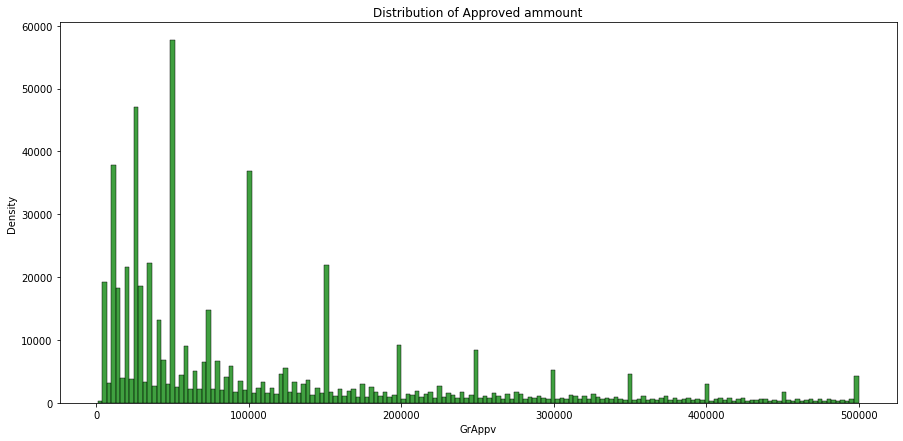

In [36]:
plt.figure(figsize=(15,7))
sns.histplot(df.GrAppv, color="green", kde=False)
plt.ylabel('Density')
plt.title('Distribution of Approved ammount')
plt.show()

##### # Observation - This plot shows the right skewedness of GrAppv, so we fix the skewness using a log function

In [37]:
df['GrAppv']=np.log(df['GrAppv'])

## 5. Data Visualization

Text(0.5, 1.0, 'Average Term vs MIS_Status')

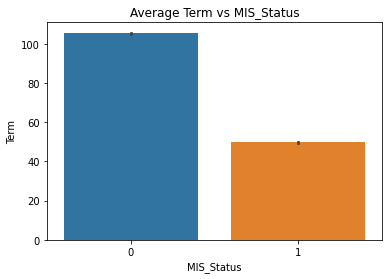

In [38]:
sns.barplot(x='MIS_Status', y='Term', data=df)
plt.title('Average Term vs MIS_Status')

Text(0.5, 1.0, 'Average DisbursementGross vs MIS_Status')

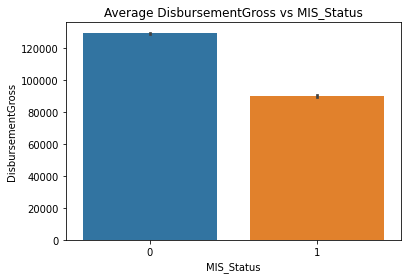

In [39]:
sns.barplot(x='MIS_Status', y='DisbursementGross', data=df)
plt.title('Average DisbursementGross vs MIS_Status')

Text(0.5, 1.0, 'Average GrAppv vs MIS_Status')

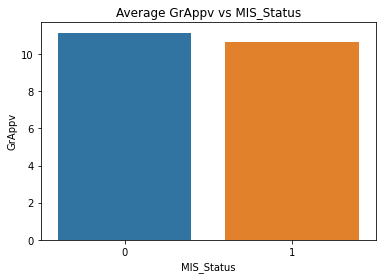

In [40]:
sns.barplot(x='MIS_Status', y='GrAppv', data=df)
plt.title('Average GrAppv vs MIS_Status')

Text(0.5, 1.0, 'Average SBA_Appv vs MIS_Status')

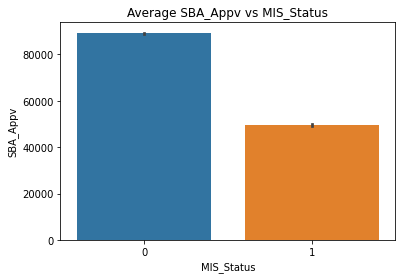

In [41]:
sns.barplot(x='MIS_Status', y='SBA_Appv', data=df)
plt.title('Average SBA_Appv vs MIS_Status')

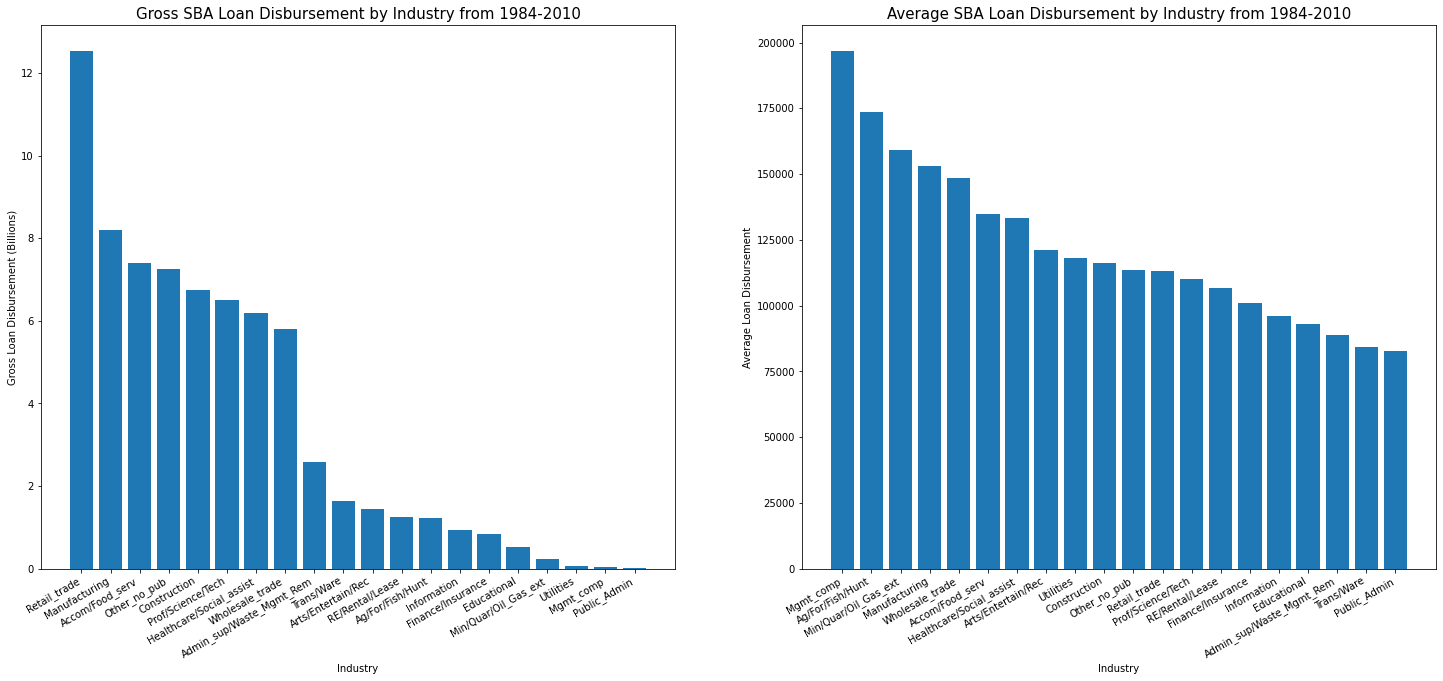

In [42]:
# Total/Average disbursed loan amount by industry
# Create a groupby object on Industry for use in visualization
industry_group = df.groupby(['Industry'])

# Data frames based on groupby by Industry looking at aggregate and average values
df_industrySum = industry_group.sum().sort_values('DisbursementGross', ascending=False)
df_industryAve = industry_group.mean().sort_values('DisbursementGross', ascending=False)

# Establish figure for placing bar charts side-by-side
fig = plt.figure(figsize=(25, 10))

# Add subplots to figure to build 1x2 grid and specify position of each subplot
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# ______ Bar chart 1 = Gross SBA Loan Disbursement by Industry ______

ax1.bar(df_industrySum.index, df_industrySum['DisbursementGross'] / 1000000000)
ax1.set_xticklabels(df_industrySum.index, rotation=30, horizontalalignment='right', fontsize=10)

ax1.set_title('Gross SBA Loan Disbursement by Industry from 1984-2010', fontsize=15)
ax1.set_xlabel('Industry')
ax1.set_ylabel('Gross Loan Disbursement (Billions)')

# ______ Bar chart 2 = Average SBA Loan Disbursement by Industry ______

ax2.bar(df_industryAve.index, df_industryAve['DisbursementGross'])
ax2.set_xticklabels(df_industryAve.index, rotation=30, horizontalalignment='right', fontsize=10)

ax2.set_title('Average SBA Loan Disbursement by Industry from 1984-2010', fontsize=15)
ax2.set_xlabel('Industry')
ax2.set_ylabel('Average Loan Disbursement')

plt.show()

#### > Loans categorized by Industry and State

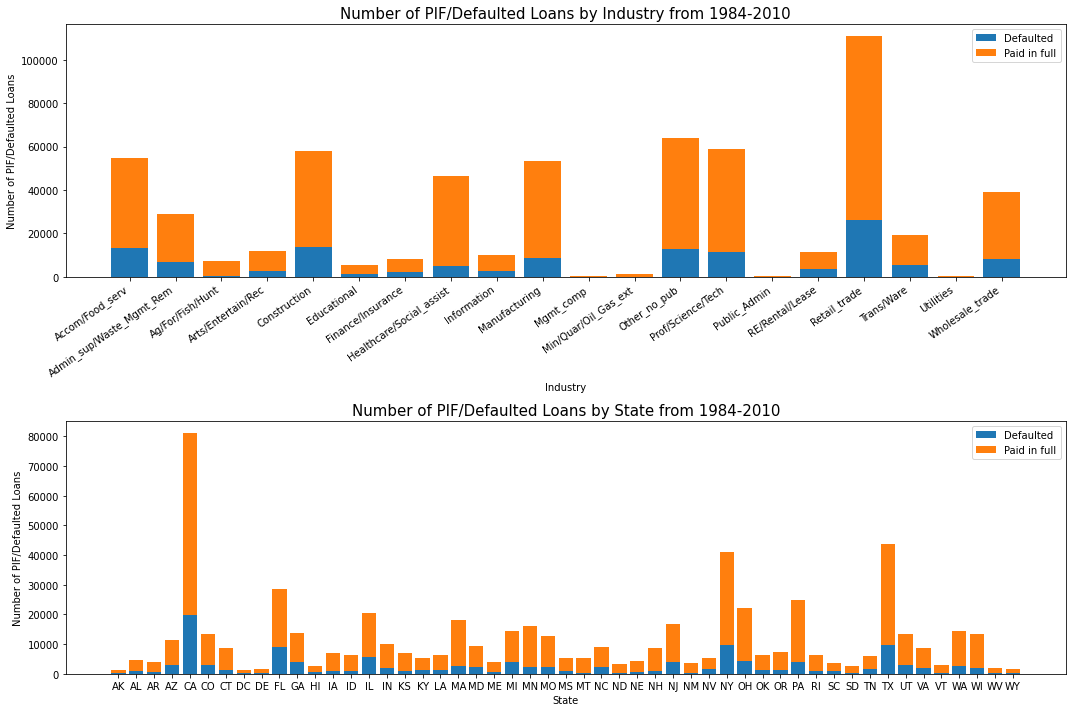

In [43]:
# Paid in full and defaulted loans

fig3 = plt.figure(figsize=(15, 10))

ax1a = plt.subplot(2, 1, 1)
ax2a = plt.subplot(2, 1, 2)

# Function for creating stacked bar charts grouped by desired column
# df = original data frame, col = x-axis grouping, stack_col = column to show stacked values
# Essentially acts as a stacked histogram when stack_col is a flag variable

def stacked_setup(df, col, axes, stack_col='MIS_Status'):
    data = df.groupby([col, stack_col])[col].count().unstack(stack_col)
    data.fillna(0)

    axes.bar(data.index, data[1], label='Defaulted')
    axes.bar(data.index, data[0], bottom=data[1], label='Paid in full')


# ______ Number of Paid in full and defaulted loans by INDUSTRY ______

stacked_setup(df=df, col='Industry', axes=ax1a)
ax1a.set_xticklabels(df.groupby(['Industry', 'MIS_Status'])['Industry'].count().unstack('MIS_Status').index,
                     rotation=35, horizontalalignment='right', fontsize=10)

ax1a.set_title('Number of PIF/Defaulted Loans by Industry from 1984-2010', fontsize=15)
ax1a.set_xlabel('Industry')
ax1a.set_ylabel('Number of PIF/Defaulted Loans')
ax1a.legend()

# ______ Number of Paid in full and defaulted loans by STATE ______

stacked_setup(df=df, col='State', axes=ax2a)

ax2a.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax2a.set_xlabel('State')
ax2a.set_ylabel('Number of PIF/Defaulted Loans')
ax2a.legend()

plt.tight_layout()
plt.show()

##### > Default percentage by Industry

In [44]:
def_ind = df.groupby(['Industry', 'MIS_Status'])['Industry'].count().unstack('MIS_Status')
def_ind['Def_Percent'] = def_ind[1]/(def_ind[1] + def_ind[0])
def_ind

MIS_Status,0,1,Def_Percent
Industry,,,
Accom/Food_serv,41580,13205,0.241033
Admin_sup/Waste_Mgmt_Rem,22226,6806,0.234431
Ag/For/Fish/Hunt,6540,561,0.079003
Arts/Entertain/Rec,9309,2660,0.222241
Construction,44179,13913,0.239499
Educational,4154,1393,0.251127
Finance/Insurance,5804,2461,0.297762
Healthcare/Social_assist,41363,5008,0.107999
Information,7290,2575,0.261024


##### > Check Default percentage by State

In [45]:
def_state = df.groupby(['State', 'MIS_Status'])['State'].count().unstack('MIS_Status')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state

MIS_Status,0,1,Def_Percent
State,,,
AK,1122,120,0.096618
AL,3734,1072,0.223055
AR,3056,768,0.200837
AZ,8295,2952,0.262470
CA,61189,19862,0.245056
CO,10338,3055,0.228104
CT,7213,1334,0.156078
DC,849,341,0.286555
DE,1164,331,0.221405


##### > Loans paid in full and Defaulted loans by DisbursementFY

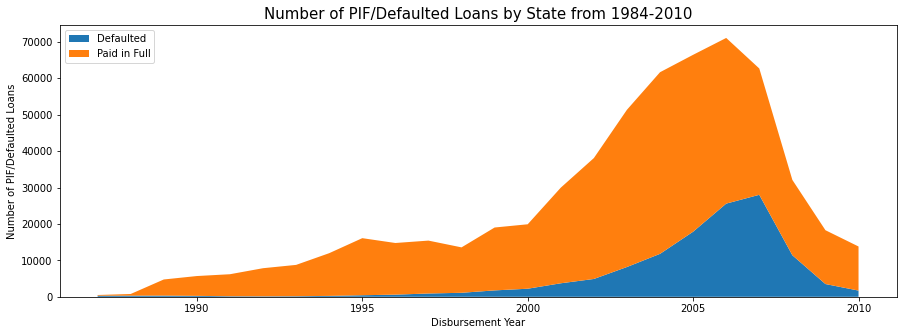

In [46]:
fig4, ax4 = plt.subplots(figsize=(15, 5))

stack_data = df.groupby(['DisbursementFY', 'MIS_Status'])['DisbursementFY'].count().unstack('MIS_Status')
x = stack_data.index
y = [stack_data[1], stack_data[0]]

ax4.stackplot(x, y, labels=['Defaulted', 'Paid in Full'])
ax4.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax4.set_xlabel('Disbursement Year')
ax4.set_ylabel('Number of PIF/Defaulted Loans')
ax4.legend(loc='upper left')

plt.show()

# We use a stacked area chart here since it's time series data

##### # Insight -

It can be clearly seen that most loans have defaulted in the time-period leading up to the Great Reccession 2008.

Also note how the number of loans have icreased until the Great Reccesion and then sharply decreased.

##### > Loans backed by Real Estate v/s Loans during the Great Recession

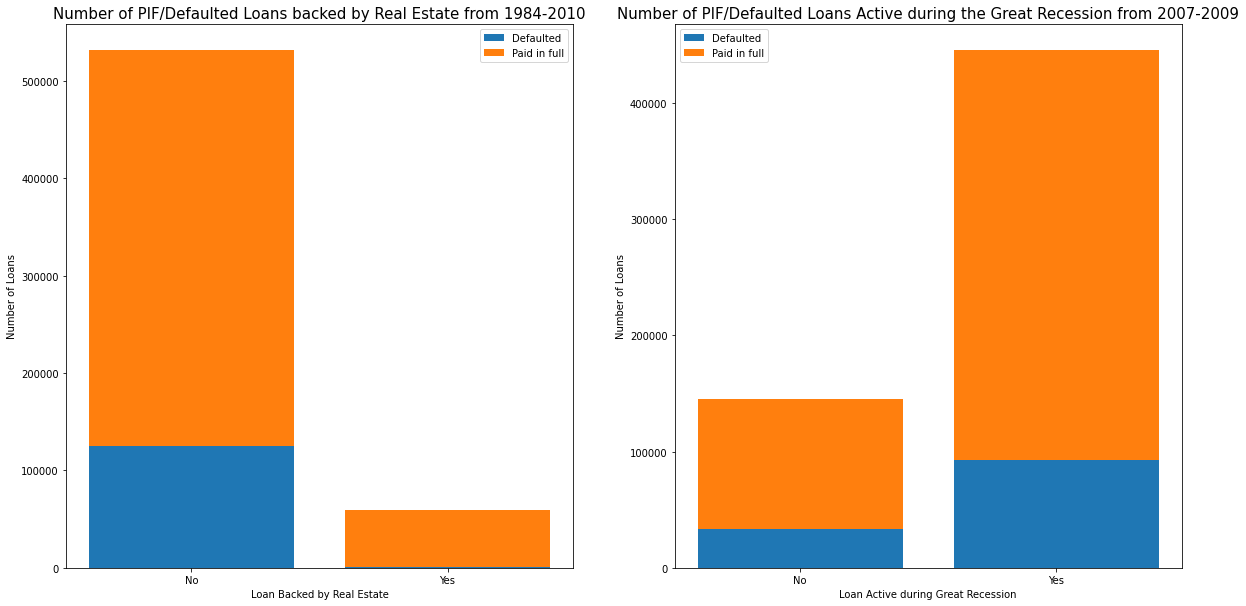

In [47]:
# _____ Paid in full and defaulted loans backed by Real Estate ______

fig5 = plt.figure(figsize=(20, 10))

ax1b = fig5.add_subplot(1, 2, 1)
ax2b = fig5.add_subplot(1, 2, 2)

stacked_setup(df=df, col='RealEstate', axes=ax1b)
ax1b.set_xticks(df.groupby(['RealEstate', 'MIS_Status'])['RealEstate'].count().unstack('MIS_Status').index)
ax1b.set_xticklabels(labels=['No', 'Yes'])

ax1b.set_title('Number of PIF/Defaulted Loans backed by Real Estate from 1984-2010', fontsize=15)
ax1b.set_xlabel('Loan Backed by Real Estate')
ax1b.set_ylabel('Number of Loans')
ax1b.legend()

# ______ Paid in full and defaulted loans active during the Great Recession ______

stacked_setup(df=df, col='GreatRecession', axes=ax2b)
ax2b.set_xticks(df.groupby(['GreatRecession', 'MIS_Status'])['GreatRecession'].count().unstack('MIS_Status').index)
ax2b.set_xticklabels(labels=['No', 'Yes'])

ax2b.set_title('Number of PIF/Defaulted Loans Active during the Great Recession from 2007-2009', fontsize=15)
ax2b.set_xlabel('Loan Active during Great Recession')
ax2b.set_ylabel('Number of Loans')
ax2b.legend()

plt.show()

During our EDA, we had already determined that the volume of loans backed by real estate was much less than those not backed by Real Estate i.e. only 10% loans were backed by Real Estate.

Surprisingly though, the default rate for loans backed by real estate is also much less as compared to those not backed by real-estate.

##### > Default percentage for loans backed by Real Estate

In [48]:
def_re = df.groupby(['RealEstate', 'MIS_Status'])['RealEstate'].count().unstack('MIS_Status')
def_re['Def_Percent'] = def_re[1]/(def_re[1] + def_re[0])
def_re

MIS_Status,0,1,Def_Percent
RealEstate,,,
0,406685,124926,0.234995
1,58488,660,0.011158


___Insight -___ 

Only 0.011% of the loans that defaulted were backed by Real Estate. On the contrary, loans not backed by Real Estate defaulted by 0.234% i.e. about 21 times more than the ones backed by Real Estate. 

Even though the default rate for loans not backed by real estate is pretty small (0.234%), it can be said that the chances of default for a loan not backed by real estate is at least 20 times more than a loan backed by real estate.

##### > Default percentage for loans active during the Great Recession

In [49]:
def_gr = df.groupby(['GreatRecession', 'MIS_Status'])['GreatRecession'].count().unstack('MIS_Status')
def_gr['Def_Percent'] = def_gr[1]/(def_gr[1] + def_gr[0])
def_gr

MIS_Status,0,1,Def_Percent
GreatRecession,,,
0,112027,33198,0.228597
1,353146,92388,0.207365


___Insight -___

Only 0.21% of the loans that defaulted were active during the Great Recession period of 2007-09. On the other hand, 0.23% of the loans defaulted during the other years. Hence, the Great Recession has not affected the default rates of Small Businesses as much.

## 6. Model Building

##### > Dummy encoding

In [50]:
df=pd.get_dummies(df)
df.head()

,ApprovalFY,Term,NewExist,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,GrAppv,...,Industry_Mgmt_comp,Industry_Min/Quar/Oil_Gas_ext,Industry_Other_no_pub,Industry_Prof/Science/Tech,Industry_Public_Admin,Industry_RE/Rental/Lease,Industry_Retail_trade,Industry_Trans/Ware,Industry_Utilities,Industry_Wholesale_trade
0,1997,84,2,0,-1,1,60000.0,0.0,0,11.002100,...,0,0,0,0,0,0,1,0,0,0
1,1997,60,2,0,-1,1,40000.0,0.0,0,10.596635,...,0,0,0,0,0,0,0,0,0,0
2,1997,180,1,0,-1,0,287000.0,0.0,0,12.567237,...,0,0,0,0,0,0,0,0,0,0
7,1997,84,2,0,-1,1,45000.0,0.0,0,10.714418,...,0,0,1,0,0,0,0,0,0,0
8,1997,297,2,0,-1,0,305000.0,0.0,0,12.628067,...,0,0,0,0,0,0,0,0,0,0


##### > Split data into train and test sets + label target value

In [51]:
y = df.MIS_Status
X = df.drop(['MIS_Status'], axis=1)

# Scale the feature values prior to modeling
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25)

#### > LOGISTIC REGRESSION

In [52]:
log_reg = LogisticRegression(random_state=0)   # Initialize model

log_reg.fit(X_train, y_train)
y_logpred = log_reg.predict(X_val)   # Train model and make predictions

print(classification_report(y_val, y_logpred, digits=3))   # Print results

              precision    recall  f1-score   support

           0      0.875     0.946     0.909    116353
           1      0.714     0.500     0.588     31337

    accuracy                          0.851    147690
   macro avg      0.795     0.723     0.749    147690
weighted avg      0.841     0.851     0.841    147690



##### # Observation -

We can see here that with the Logistic Regression model, we have a surprising accuracy of 85%, and the F1-score of 60% for defaulted loans doesn't seem promising at all. The precision suggests that the model is correct 70% of the time when the loan defaults, and the recall suggests that the model identifies only a 50% of defaulted loans correctly. That means that every one of two loans that defaulted were incorrectly classified as loans that would be paid in full, which is horribly bad business for any loan providing entity.

#### > DECISION TREES

In [53]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

pred = dtc.predict(X_val)

print(classification_report(y_val, pred))
print(confusion_matrix(y_val, pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    116353
           1       0.82      0.82      0.82     31337

    accuracy                           0.92    147690
   macro avg       0.88      0.88      0.88    147690
weighted avg       0.92      0.92      0.92    147690

[[110706   5647]
 [  5782  25555]]


##### # note how our scores have increased vastly as compared to Logistic Regression

#### > XGBOOST

In [54]:
xgboost = XGBClassifier(random_state=0)

xgboost.fit(X_train, y_train)
y_xgbpred = xgboost.predict(X_val)

print(classification_report(y_val, y_xgbpred, digits=3))

              precision    recall  f1-score   support

           0      0.964     0.970     0.967    116353
           1      0.884     0.864     0.874     31337

    accuracy                          0.947    147690
   macro avg      0.924     0.917     0.920    147690
weighted avg      0.947     0.947     0.947    147690



##### # scores have increased slightly more than Decision Trees, we can still tune hyperparameters if we want to

#### > List the importance of each feature

In [55]:
for name, importance in sorted(zip(X.columns, xgboost.feature_importances_)):
    print(name, "=", round(importance*100,3), "%")

ApprovalFY = 6.334 %
BalanceGross = 0.0 %
DisbursementFY = 1.955 %
DisbursementGross = 1.0 %
Franchise = 0.659 %
GrAppv = 1.365 %
GreatRecession = 2.445 %
Industry_Accom/Food_serv = 0.52 %
Industry_Admin_sup/Waste_Mgmt_Rem = 0.307 %
Industry_Ag/For/Fish/Hunt = 0.757 %
Industry_Arts/Entertain/Rec = 0.351 %
Industry_Construction = 0.354 %
Industry_Educational = 0.19 %
Industry_Finance/Insurance = 0.727 %
Industry_Healthcare/Social_assist = 2.402 %
Industry_Information = 0.103 %
Industry_Manufacturing = 0.487 %
Industry_Mgmt_comp = 0.0 %
Industry_Min/Quar/Oil_Gas_ext = 0.623 %
Industry_Other_no_pub = 0.837 %
Industry_Prof/Science/Tech = 0.729 %
Industry_Public_Admin = 0.0 %
Industry_RE/Rental/Lease = 0.702 %
Industry_Retail_trade = 0.954 %
Industry_Trans/Ware = 0.451 %
Industry_Utilities = 0.168 %
Industry_Wholesale_trade = 0.322 %
LowDoc = 1.169 %
NewExist = 0.968 %
RealEstate = 0.0 %
RevLineCr = 2.884 %
SBA_Appv = 1.151 %
SBA_ApvPct = 2.906 %
State_AK = 0.427 %
State_AL = 0.753 %
State_

##### # Observations -

Top 5 features : 
    Term (17%)
    --> ApprovalFY (6%)
    --> SBA_ApvPct (3.4%)
    --> State_CA (3.3%)
    --> State_FL (2.8%)


Top 3 industries : 
    Healthcare (2.2%)
    --> Rental/Lease (1.1%) 
    --> Retail_Trade (1.1%)

RealEstate has 0 effect on loan default, understandably since people taking such a risk have a pretty good plan

##### > Let's see if reducing the number of features used to the most important ones would have a positive impact on the model performance, since the current model has a high level of dimensionality.

In [56]:
from sklearn.pipeline import Pipeline   # Build pipeline for feature selection and modeling 
from sklearn.feature_selection import SelectKBest   # SelectKBest defaults to top 10 features

xgb_featimp = XGBClassifier(random_state=0)
pipe = Pipeline(steps=[ ('feature_selection', SelectKBest()), ('model', xgb_featimp) ])

pipe.fit(X_train, y_train)
y_featimppred = pipe.predict(X_val)

print(classification_report(y_val, y_featimppred, digits=3))

              precision    recall  f1-score   support

           0      0.962     0.966     0.964    116353
           1      0.871     0.859     0.865     31337

    accuracy                          0.943    147690
   macro avg      0.916     0.912     0.914    147690
weighted avg      0.943     0.943     0.943    147690



##### # Reducing the number of features, and thereby dimensionality of the data, didn't affect the results too much.

##### > List the importance of each feature for the lower dimensionality dataframe

In [57]:
for name, importance in sorted(zip(X.columns, xgb_featimp.feature_importances_)):
    print(name, "=", round(importance*100,3), "%")

ApprovalFY = 17.509 %
BalanceGross = 10.056 %
DisbursementGross = 2.89 %
GrAppv = 0.0 %
LowDoc = 3.271 %
NewExist = 4.561 %
RevLineCr = 2.523 %
SBA_Appv = 5.327 %
Term = 49.748 %
UrbanRural = 4.115 %


##### # Observation -

Top 5 features are now Term (50%), ApprovalFY (16%), BalanceGross (10%), SBA_Appv (5.5%), NewExist (4.5%)

Note how ApprovalFY and Term are the only initial features on this new Top 5 list

## CONCLUSION

1. Only 0.011% of loans that Small Businesses defaulted on were backed by Real Estate. On the contrary, loans not backed by Real Estate defaulted by 0.234% i.e. about 21 times more than the ones backed by Real Estate. Even though the default rate for loans not backed by Real Estate is very low (0.234%), it can be said that a Small Business' probability of defaulting on a loan not backed by Real Estate is at least 20 times more than for a loan backed by Real Estate.

2. Only 0.21% of the loans that Small Businesses defaulted on were active during the Great Recession period of 2007-09. On the other hand, Small Businesses defaulted on 0.23% of the loans during the other years. Hence, the Great Recession has not affected the default rates of Small Businesses as much.